In [1]:
# Can we taste with our eyes?
# Qingwei Zhang, Christopher Song, Karen Chen
# Analysis script

# DATASET INFO
# raw: Smeets, et al. (2013) - subj 1

import numpy as np
from nilearn import datasets, plotting, image, input_data
from matplotlib import pyplot as pl
%matplotlib inline
from sklearn import neighbors, metrics, model_selection
from scipy import stats as spst

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 9

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/base.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils.seq_dataset import ArrayDataset, CSRDataset
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils import arrayfuncs, as_float_array, check_X_y, deprecated
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:29: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import cd_fast
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/linear_model/__init__.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. 

In [2]:
#############################################
# LOADING DATA ------------------------------
#############################################

# configuration settings, with print to confirm:
#  - fMRI imaging data filename
#  - fMRI amygdala mask filename
# NOTE: keep script within the same directory as files
# refer to project paper for pre-processing details
anat_fname = 'sub-01-anat-sub-01_T1w.nii.gz'
fmri_fname = 'trans_filtered_func_data_3mm.nii.gz'
mask_fname = 'binary-amygdala-mni-sym_3mm_mask.nii.gz'
print("anatomical MRI filename: " + anat_fname)
print("functional MRI filename: " + fmri_fname)
print("amygdala mask filename: " + anat_fname)

anatomical MRI filename: sub-01-anat-sub-01_T1w.nii.gz
functional MRI filename: trans_filtered_func_data_3mm.nii.gz
amygdala mask filename: sub-01-anat-sub-01_T1w.nii.gz


In [3]:
# load fMRI data, print original affine and shape
# verify mask has same spatial resolution as all images in fMRI series
# things to note:
#  - all data pre-processed to 3mm fMRI resolution
#  - amygdala mask data stripped of low-level metadata, affine, etc.
fmri_img = image.load_img(fmri_fname)
amyg_mask = image.load_img(mask_fname)#.get_data()

print("fMRI image affine:")
print(fmri_img.affine)
print
print("fMRI image shape:")
print(fmri_img.shape)
print
print("amygdala mask shape:")
print(amyg_mask.shape)

fMRI image affine:
[[   3.    0.    0.  -90.]
 [   0.    3.    0. -126.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]

fMRI image shape:
(61, 73, 61, 375)

amygdala mask shape:
(61, 73, 61)


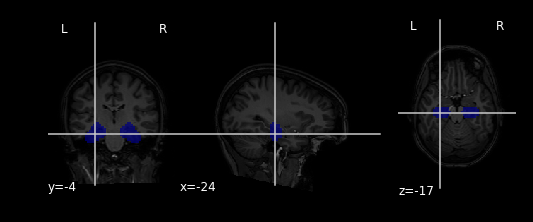

In [4]:
# plot region-of-interest (ROI)
plotting.plot_roi(amyg_mask, bg_img = anat_fname)

In [5]:
# close plot
pl.close()

# create instance of NiftiMasker for amygdala mask
masker = input_data.NiftiMasker(amyg_mask, standardize = True)

# apply mask to fMRI data, strip metadata, transform to sample-by-feature
fmri_masked = masker.fit_transform(fmri_img)

# print dimensions to compare
print('Original whole-brain data shape:')
print(fmri_img.shape)
print
print('After masking:')
print(fmri_masked.shape)

Original whole-brain data shape:
(61, 73, 61, 375)

After masking:
(375, 614)


In [6]:
#############################################
# DECODING ----------------------------------
#############################################

lbl_fname = 'labels.txt'

# read text file and store labels (category and run) of the samples in two lists
n_samples = fmri_img.shape[3]
ctgs = []
runs = np.zeros(n_samples, dtype=int)

# open file/obtain all data (discard first line first)
f = open(lbl_fname,'r')
f.readline()
for iline, line in enumerate(f.readlines()):
    (ctg, run) = line.rstrip().split(' ')
    ctgs.append(ctg)
    runs[iline] = int(run)
f.close()

# convert to numpy array
ctgs = np.asarray(ctgs)
print('Total # samples: n = %d' % len(ctgs))
print('Total # runs: k = %d' % (np.max(runs) + 1))

Total # samples: n = 375
Total # runs: k = 8


In [7]:
# experimental conditions + details about them
experimentalConditons = np.unique(ctgs)
print('Experimental conditions:')
print(experimentalConditons)
print

for ic, cond in enumerate(experimentalConditons):
    print('\'%s\' condition has %d samples.' % (cond, np.sum(ctgs == cond)))
print

print('Importantly, the \'food\' and \'nonfood\' conditions have an equal number of samples.')
print('The \'break\' condition has more samples than the other two conditions; however,')
print('as this condition does not hold useful data, this does not affect the study.')

Experimental conditions:
['break' 'food' 'nonfood']

'break' condition has 135 samples.
'food' condition has 120 samples.
'nonfood' condition has 120 samples.

Importantly, the 'food' and 'nonfood' conditions have an equal number of samples.
The 'break' condition has more samples than the other two conditions; however,
as this condition does not hold useful data, this does not affect the study.


In [8]:
# number of samples per run
for i in range(8):
    print('Run %d has %d samples.' % (i, np.sum(runs == i)))

Run 0 has 55 samples.
Run 1 has 41 samples.
Run 2 has 47 samples.
Run 3 has 51 samples.
Run 4 has 47 samples.
Run 5 has 44 samples.
Run 6 has 43 samples.
Run 7 has 47 samples.


In [9]:
# create boolean mask to discard all data from 'break' condition
lbls_of_the_targ_ctgs = np.asarray([ctg != 'break' for ctg in ctgs])
ds = fmri_masked[lbls_of_the_targ_ctgs]
targCtgs = ctgs[lbls_of_the_targ_ctgs]
targRuns = runs[lbls_of_the_targ_ctgs]

print("Original dataset shape:")
print(fmri_masked.shape)
print

print("Shape of boolean mask:")
print(lbls_of_the_targ_ctgs.shape)
print

print("Shape of dataset, after removing 'break' data:")
print(ds.shape)
print

categories = np.unique(targCtgs)
n_categories = len(categories)

print("Total of %s categories assessed:" % n_categories)
print(categories)

Original dataset shape:
(375, 614)

Shape of boolean mask:
(375,)

Shape of dataset, after removing 'break' data:
(240, 614)

Total of 2 categories assessed:
['food' 'nonfood']


In [10]:
#############################################
# CLASSIFICATION ANALYSIS -------------------
#############################################

# 1. Create classifier

# create an instance of the k-NN classifier, with all sklearn default settings
clf = neighbors.KNeighborsClassifier()

# train classifier on dataset and true labels
clf.fit(ds, targCtgs)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [11]:
# calculate predictions
lbls_pred = clf.predict(ds)

# print out predictions vs. actual in a nice table
print("%s predictions made:" % len(lbls_pred))
print
print('{:15s}{:15s}'.format('Prediction','Actual'))
print('---------------------------')
for d, c in zip(lbls_pred, targCtgs):
    print('{:15s}{:15s}'.format(d,c))
print

# accuracy
print('Accuracy on this dataset (not very meaningful, as it is specific to this dataset):')
print(metrics.accuracy_score(targCtgs, lbls_pred))

240 predictions made:

Prediction     Actual         
---------------------------
food           food           
food           food           
nonfood        food           
food           food           
food           food           
food           food           
food           food           
food           food           
food           food           
food           food           
food           food           
nonfood        food           
food           food           
food           food           
food           food           
nonfood        nonfood        
nonfood        nonfood        
nonfood        nonfood        
nonfood        nonfood        
food           nonfood        
nonfood        nonfood        
nonfood        nonfood        
nonfood        nonfood        
nonfood        nonfood        
nonfood        nonfood        
nonfood        nonfood        
nonfood        nonfood        
nonfood        nonfood        
nonfood        nonfood        
nonfood        nonf

In [12]:
# 2. Apply leave-one-run-out cross-validation (LOOCV)

# create an instance of the LOOCV class
cv = model_selection.LeaveOneGroupOut()
print('# runs: %s' % cv.get_n_splits(ds, targCtgs, groups = runs))
print
print

# print indices for test sets at each iteration of CV
print("Indices for test values at each CV iteration:")
print
for iFold, (id_trainSet, id_testSet) in enumerate(cv.split(ds, targCtgs, groups = targRuns)):
    print("%d-th CV-fold:" % iFold)
    print(id_testSet)
    print

# runs: 8


Indices for test values at each CV iteration:

0-th CV-fold:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

1-th CV-fold:
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]

2-th CV-fold:
[60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89]

3-th CV-fold:
[ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]

4-th CV-fold:
[120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149]

5-th CV-fold:
[150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179]

6-th CV-fold:
[180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209]

7-th CV-fold:
[210 211 212 213 214 215 216 217 218 219 220 221 22

In [13]:
# get sample indices of the training/test datasets of each CV iteration

# confusion matrix to keep track of results
confMat = np.zeros((n_categories, n_categories))
accuracies = []

for icv, (id_trainSet, id_testSet) in enumerate(cv.split(ds, targCtgs, targRuns)):
    print('CV %d-th iteration:' % icv)
    
    # use indices to get training/test sets from dataset
    trainSet = ds[id_trainSet]
    testSet = ds[id_testSet]
    print('training dataset shape: %s' % (trainSet.shape,))
    print('test dataset shape: %s' % (testSet.shape,))
    
    # use indices to get sample labels for training/test sets
    lbl_train = targCtgs[id_trainSet]
    lbl_true = targCtgs[id_testSet]
    
    # use fit, predict functions of our classifier
    clf.fit(trainSet, lbl_train)
    lbl_pred = clf.predict(testSet)
    
    # calculate accuracy, add to accuracies array to keep track
    acc = metrics.accuracy_score(lbl_true, lbl_pred)
    accuracies.append(acc)
    print('accuracy: %f,' % acc)

    # confusion matrix
    cm = metrics.confusion_matrix(lbl_true, lbl_pred, categories)
    print('confusion matrix:')
    print(cm)
    confMat = confMat + cm
    print

CV 0-th iteration:
training dataset shape: (210, 614)
test dataset shape: (30, 614)
accuracy: 0.733333,
confusion matrix:
[[ 9  6]
 [ 2 13]]

CV 1-th iteration:
training dataset shape: (210, 614)
test dataset shape: (30, 614)
accuracy: 0.766667,
confusion matrix:
[[10  5]
 [ 2 13]]

CV 2-th iteration:
training dataset shape: (210, 614)
test dataset shape: (30, 614)
accuracy: 0.633333,
confusion matrix:
[[ 9  6]
 [ 5 10]]

CV 3-th iteration:
training dataset shape: (210, 614)
test dataset shape: (30, 614)
accuracy: 0.733333,
confusion matrix:
[[14  1]
 [ 7  8]]

CV 4-th iteration:
training dataset shape: (210, 614)
test dataset shape: (30, 614)
accuracy: 0.566667,
confusion matrix:
[[12  3]
 [10  5]]

CV 5-th iteration:
training dataset shape: (210, 614)
test dataset shape: (30, 614)
accuracy: 0.700000,
confusion matrix:
[[ 9  6]
 [ 3 12]]

CV 6-th iteration:
training dataset shape: (210, 614)
test dataset shape: (30, 614)
accuracy: 0.466667,
confusion matrix:
[[6 9]
 [7 8]]

CV 7-th it

Overall confusion matrix:


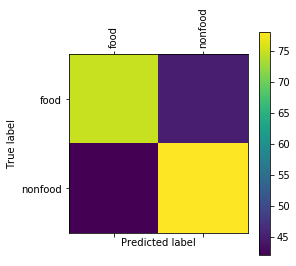

Total sum of all confusion matrix elements: 240.0


In [14]:
# overall confusion matrix visualization
print('Overall confusion matrix:')
pl.matshow(confMat)
pl.colorbar()
pl.xticks(range(n_categories), categories, rotation=90)
pl.yticks(range(n_categories), categories)
pl.xlabel('Predicted label')
pl.ylabel('True label')
pl.show()

print('Total sum of all confusion matrix elements: %s' % np.sum(confMat))

In [15]:
pl.close()

# calculate chance level
chanceLevel = 1./n_categories
print('Probability of accurate classification by chance (\"on accident\"): %s' % chanceLevel)

# calculate mean accuracy of all CV iterations
print('Mean accuracy: %.4f +/- %.4f' % (np.mean(accuracies),np.std(accuracies)))
print

print('Notably, the mean accuracy of our model appears to be higher than chance.')

Probability of accurate classification by chance ("on accident"): 0.5
Mean accuracy: 0.6375 +/- 0.1073

Notably, the mean accuracy of our model appears to be higher than chance.


In [17]:
# 3. Conduct tests for statistical significance

#  a) one-sample t-test
print('One-sample t-test:')

# calculate t- and p-values
tvalue, pvalue = spst.ttest_1samp(accuracies, 0.5)
print('  t = %.4f' % tvalue)
print('  p-value (two-tailed) = %.8f' % pvalue)

One-sample t-test:
  t = 3.3908
  p-value (two-tailed) = 0.01158630


In [18]:
#  b) binomial test
print('Binomial test:')

# obtain number of successful classifications from confusion matrix values
# sum of diagonals = correct classifications
# sum of all = total # samples
n_success = np.sum(np.diag(confMat))
n_total = np.sum(confMat)

# calculate binomial value
bino_p = spst.binom_test(n_success, n_total)
print('  %d correct classifications out of %d' % (n_success, n_total))
print('  p-value (binomial) = %.8f' % bino_p)
print

print('Sum of each column:')
print np.sum(confMat, axis = 0)
print('Sum of each row:')
print np.sum(confMat, axis = 1)

Binomial test:
  153 correct classifications out of 240
  p-value (binomial) = 0.00002437

Sum of each column:
[117. 123.]
Sum of each row:
[120. 120.]


In [19]:
#  c) permutation test (unparametric)
print('Permutation (unparametric) test:')

# calculate empirical null distribution by permuting category labels
lbls_random = np.random.permutation(targCtgs)

# perform same clf analysis using random labels
# output accuracy should be random
accuracies_random = []
for icv, (id_trainSet, id_testSet) in enumerate(cv.split(ds, lbls_random, targRuns)):
    # same training/test sets
    trainSet = ds[id_trainSet]
    testSet = ds[id_testSet]

    # randomly ordered labels
    lbl_train = lbls_random[id_trainSet]
    lbl_true = lbls_random[id_testSet]

    # same fit/predict functions of previous classifier
    clf.fit(trainSet, lbl_train)
    lbl_pred = clf.predict(testSet)

    # calculate accuracy, keep track of each accuracy
    acc = metrics.accuracy_score(lbl_true, lbl_pred)
    accuracies_random.append(acc)
    print('  CV %d-th iter: accuracy = %f' % (icv, acc))
print

# mean random accuracy
print('  Mean random accuracy: %.4f +/- %.4f' % (np.mean(accuracies_random),np.std(accuracies_random)))

Permutation (unparametric) test:
  CV 0-th iter: accuracy = 0.366667
  CV 1-th iter: accuracy = 0.533333
  CV 2-th iter: accuracy = 0.566667
  CV 3-th iter: accuracy = 0.433333
  CV 4-th iter: accuracy = 0.433333
  CV 5-th iter: accuracy = 0.533333
  CV 6-th iter: accuracy = 0.566667
  CV 7-th iter: accuracy = 0.533333

  Mean random accuracy: 0.4958 +/- 0.0696


In [20]:
# generate empirical distribution by repeating N times
N = 100
random_dist = np.zeros(N)
print('Generating empirical distribution')
print('  repeating above CV %d times...' % N)
print

# keep track of time, in case it takes too long
import time
t1 = time.time()

# repeat 100 sets of the above CV
for it in range(N):
    lbls_random = np.random.permutation(targCtgs)
    accuracies_random = []
    
    # exact copy of above cross-validator
    for icv, (id_trainSet, id_testSet) in enumerate(cv.split(ds, lbls_random, targRuns)):
        # same training/test sets
        trainSet = ds[id_trainSet]
        testSet = ds[id_testSet]

        # randomly ordered labels
        lbl_train = lbls_random[id_trainSet]
        lbl_true = lbls_random[id_testSet]

        # same fit/predict functions of previous classifier
        clf.fit(trainSet, lbl_train)
        lbl_pred = clf.predict(testSet)

        # calculate accuracy, keep track of each accuracy
        acc = metrics.accuracy_score(lbl_true, lbl_pred)
        accuracies_random.append(acc)
    random_dist[it] = np.mean(accuracies_random)
    # print mean accuracy every 10 iterations
    if np.mod(it, 10)==0:
        print('  CV %d-th iter: mean accuracy = %.4f' % (it, random_dist[it]))
        
t2 = time.time()
deltaT = t2-t1

print
print("time elapsed: %.4fs" % (deltaT/60))

Generating empirical distribution
  repeating above CV 100 times...

  CV 0-th iter: mean accuracy = 0.4958
  CV 10-th iter: mean accuracy = 0.5208
  CV 20-th iter: mean accuracy = 0.4583
  CV 30-th iter: mean accuracy = 0.5208
  CV 40-th iter: mean accuracy = 0.5667
  CV 50-th iter: mean accuracy = 0.4625
  CV 60-th iter: mean accuracy = 0.5167
  CV 70-th iter: mean accuracy = 0.4958
  CV 80-th iter: mean accuracy = 0.5042
  CV 90-th iter: mean accuracy = 0.4792

time elapsed: 0.1005s


Null distribution:


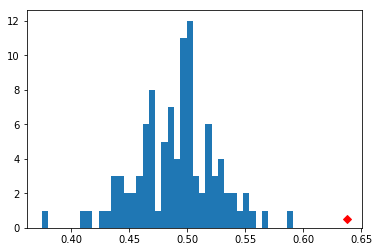

As expected, the null distribution appears to be a normal-like distribution centered at 0.5.
Notably, our real mean accuracy (shown by the red diamond) is far greater than the null distribution mean.

p-value (permutation): 0.000000

Also notably, our permutation p-value is 0. This means that none of the accuracies generated during these
100 iterations was greater than our real mean accuracy. This suggests a very statistically significant
probability that our achieved accuracy was not due to chance.


In [21]:
# plot null distribution
print('Null distribution:')
pl.hist(random_dist,bins=40)

# calculate, plot real accuracy
real_acc = np.mean(accuracies)
pl.plot(real_acc,.5,'rD')
pl.show()
print('As expected, the null distribution appears to be a normal-like distribution centered at 0.5.')
print('Notably, our real mean accuracy (shown by the red diamond) is far greater than the null distribution mean.')
print

# calculate permutation p-value
# (%age of times nonsense accuracy > actual accuracy)
print('p-value (permutation): %f' % (np.sum(random_dist > real_acc) / (1. * N)))
print

print('Also notably, our permutation p-value is 0. This means that none of the accuracies generated during these')
print('%d iterations was greater than our real mean accuracy. This suggests a very statistically significant' % N)
print('probability that our achieved accuracy was not due to chance.')

In [22]:
pl.close()